In [1]:
# BiocManager::install("philr")
# BiocManager::install("phyloseq")
# BiocManager::install("microbiome")
# install.packages("RColorBrewer")
# install.packages("UpSetR")
# install.packages("ggfortify")
# install.packages("randomForest")
# install.packages("rfUtilities")
# install.packages("phytools")
# install.packages("gridExtra")
# install.packages("remotes")
# install.packages('devtools')
# install.packages("intergraph")
# devtools::install_github('reptalex/phylofactor')
# devtools::install_github("briatte/ggnet")
# remotes::install_github("vmikk/metagMisc")
# remotes::install_github("pmartinezarbizu/pairwiseAdonis/pairwiseAdonis")
# remotes::install_github("gauravsk/ranacapa")
# install.packages("ggdendro")

In [1]:
library(philr, warn.conflicts = F, quietly = T)
library(RColorBrewer, warn.conflicts = F, quietly = T)
library(UpSetR, warn.conflicts = F, quietly = T)
library(ggfortify, warn.conflicts = F, quietly = T)
library(randomForest, warn.conflicts = F, quietly = T)
library(rfUtilities, warn.conflicts = F, quietly = T)
library(phytools, warn.conflicts = F, quietly = T)
library(phyloseq, warn.conflicts = F, quietly = T)
library(gridExtra, warn.conflicts = F, quietly = T)
library(microbiome, warn.conflicts = F, quietly = T)
library(phylofactor, warn.conflicts = F, quietly = T)
library(dplyr, warn.conflicts = F, quietly = T)
library(pairwiseAdonis, warn.conflicts = F, quietly = T)
library(ape, warn.conflicts = F, quietly = T)
library(metagMisc, warn.conflicts = F, quietly = T)
library(ranacapa, warn.conflicts = F, quietly = T)
library(MASS, warn.conflicts = F, quietly = T)
library(ggdendro, warn.conflicts = F, quietly = T)

Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘lattice’


The following object is masked from ‘package:UpSetR’:

    histogram


This is vegan 2.6-2


Attaching package: ‘vegan’


The following object is masked from ‘package:microbiome’:

    diversity


The following object is masked from ‘package:phytools’:

    scores



Attaching package: ‘cluster’


The following object is masked from ‘package:maps’:

    votes.repub




In [2]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/mann/miniconda3/envs/2022-ADS_plaque-R/lib/libopenblasp-r0.3.20.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggdendro_0.1.23      MASS_7.3-58.1        ranacapa_0.1.0      
 [4] metagMisc_0.0.4      pairwiseAdonis_0.4   cluster_2.1.4       
 [7] vegan_2.6-2          lattice_0.20-45      permute_0.9-7       
[10] dplyr_1.0.10         phylofactor_0.0.1    Matrix_1.5-1        
[13] data.table_1.14.4    magrittr_2.0.3       microbiome_1.16.0   
[16] gridExtra_2.3        phyloseq_1.38.0      phytools_1.2-0      
[19] maps_3.4.0           ape_5.6-2            rfUtilities_2.1-5   
[22] randomForest_4.7-1.1 ggfortify_0.4.14     ggplot2_3.3.6       
[25] UpSetR_1.4.0         RColo

In [3]:
seqtab <- read.table("sequence_table.merged.txt", header=T, row.names=1)
tax <- read.table("taxonomy_bac.txt", header=F, row.names=1, sep="\t")
tree <- read.tree("RAxML_bestTree.ref.tre")
tree.root <- midpoint.root(tree)

In [4]:
map <- read.table("../03-diff_abundance/map.txt", sep="\t", header=T, row.names=1)
notinmeta <- setdiff(row.names(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), row.names(seqtab))
print("Samples found in ASV table but not in metadata:")
notinmeta
print("Samples found in metadata but not in sequencing table:")
notinraw

[1] "Samples found in ASV table but not in metadata:"


[1] "UF102PFR" "UF54PER"  "UF69PD"

[1] "Samples found in metadata but not in sequencing table:"


character(0)

In [5]:
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=F), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3270 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3270 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3270 tips and 3269 internal nodes ]

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


pdf 
  2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3106 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3106 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3106 tips and 3105 internal nodes ]

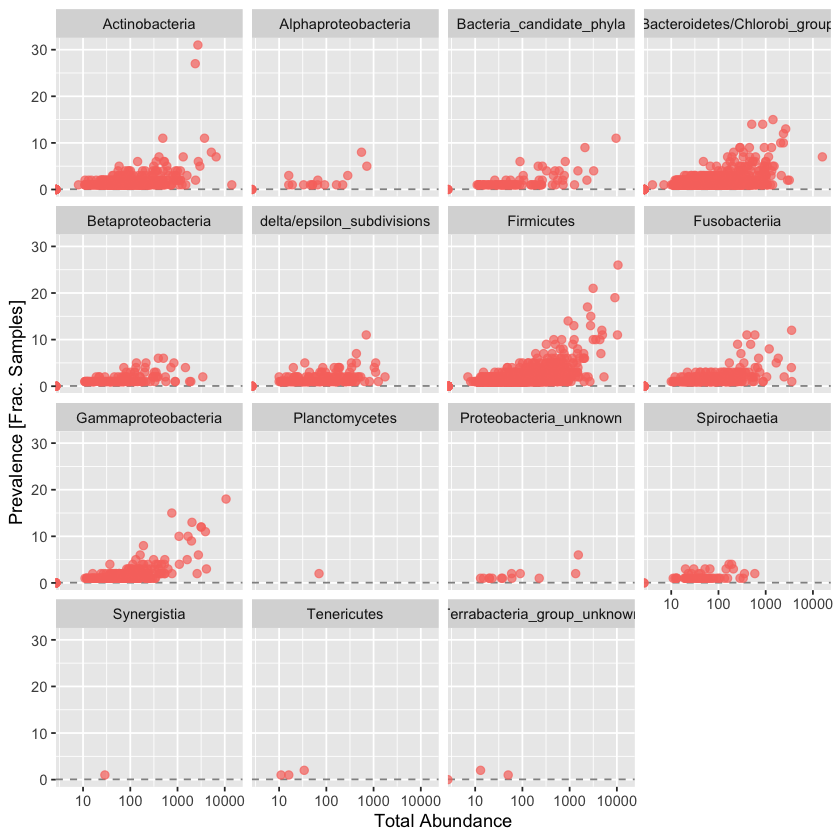

In [6]:
# compute prevalence dataframe
prevdf <- apply(X=otu_table(ps.dat), MARGIN=ifelse(taxa_are_rows(ps.dat), yes=1, no=2), FUN=function(x){sum(x>0)})
# add taxa and total read counts to dataframe
prevdf <- data.frame(Prevalence=prevdf, TotalAbundance=taxa_sums(ps.dat), tax_table(ps.dat))
# which phyla are comprised as mostly low prevalence ASVs?
lowprev <- ggplot(prevdf, aes(TotalAbundance, Prevalence, nsamples(ps.dat), color="V4")) + geom_hline(yintercept=0.05, alpha=0.5, linetype=2) + geom_point(size=2, alpha=0.7) + scale_x_log10() + xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") + facet_wrap(~V4) + theme(legend.position="none")
lowprev
pdf("totalabund_vs_prevalence.pdf")
lowprev
dev.off()
# kept asvs must be found in at least 1% of all samples 
ps.dat <- phyloseq_filter_prevalence(ps.dat, prev.trh=0.01)
ps.dat

In [7]:
# filter out samples with fewer than 1000 reads (based on ASV rareness, this shouldn't be an issue)
ps.dat <- prune_samples(sample_sums(ps.dat) > 1000, ps.dat)
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3106 taxa and 68 samples ]
sample_data() Sample Data:       [ 68 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3106 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3106 tips and 3105 internal nodes ]

In [8]:
# write filtered tables to file
write.table(as.data.frame(otu_table(ps.dat)), "sequence_table.filt.txt", sep="\t", row.names=T, col.names=T)
# write filtered taxonomy to file
write.table(as.data.frame(tax_table(ps.dat)), "taxonomy_bac.filt.txt", sep="\t", row.names=T, col.names=T)
# filtered metadata
write.table(as.data.frame(sample_data(ps.dat)), "map.filt.txt", sep="\t", row.names=T, col.names=T)

In [9]:
# top phyla across samples (relative abundance data)
rel.abund <- transform_sample_counts(ps.dat, function(x) x/sum(x)) # get relative abundance
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[3]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V4 <- as.character(data$V4) # convert to character
data$V4[data$Abundance < 0.01] <- "< 1% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V4, function(x) c(median=median(x$Abundance)))
medians

V4,median
<chr>,<dbl>
< 1% abund,0.00000000
Actinobacteria,0.09938477
Alphaproteobacteria,0.02118989
Bacteria_candidate_phyla,0.04122582
Bacteroidetes/Chlorobi_group,0.21508944
Betaproteobacteria,0.03364799
delta/epsilon_subdivisions,0.03430552
Firmicutes,0.35167176
Fusobacteriia,0.06442105


In [10]:
# most common genera
glom <- tax_glom(rel.abund, taxrank=rank_names(rel.abund)[8]) # collapse 
data <- psmelt(glom) # create dataframe from phyloseq object
data$V8 <- as.character(data$V8) # convert to character
data$V8[data$Abundance < 0.20] <- "< 20% abund" # rename low freq phyla
medians <- plyr::ddply(data, ~V8, function(x) c(median=median(x$Abundance)))
medians

V8,median
<chr>,<dbl>
< 20% abund,0.0000000
Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown,0.2181794
Cardiobacterium_valvarum,0.2519882
Corynebacterium,0.2174710
Flavobacteriaceae,0.3938660
Haemophilus_unknown,0.2278329
Lachnospiraceae_unknown,0.2374552
Lautropia_mirabilis,0.3711180
Porphyromonadaceae,0.3551041


pdf 
  2

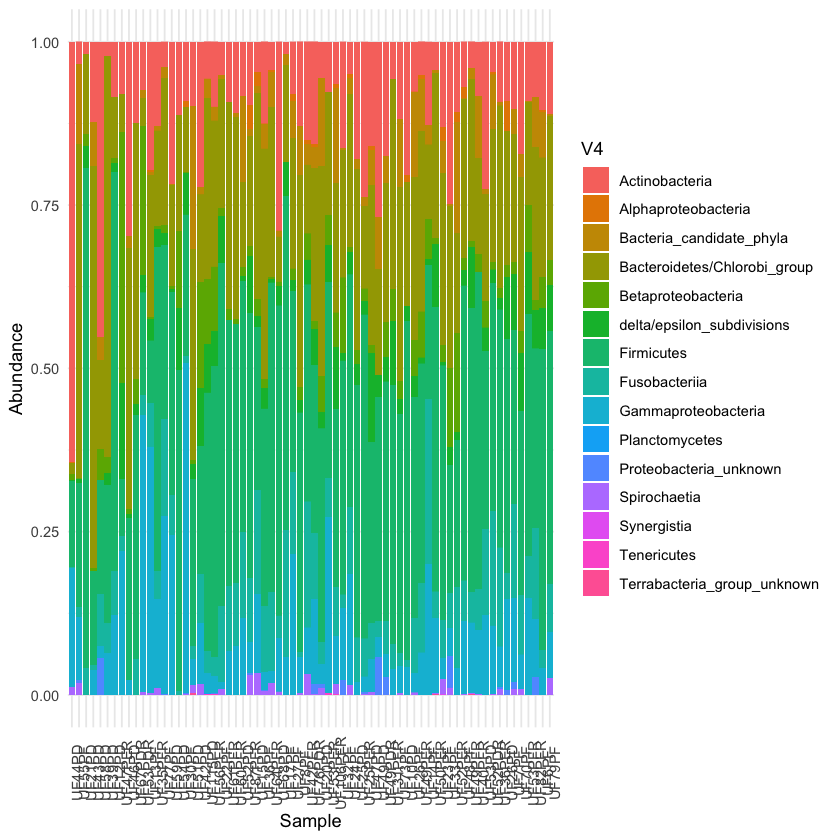

pdf 
  2

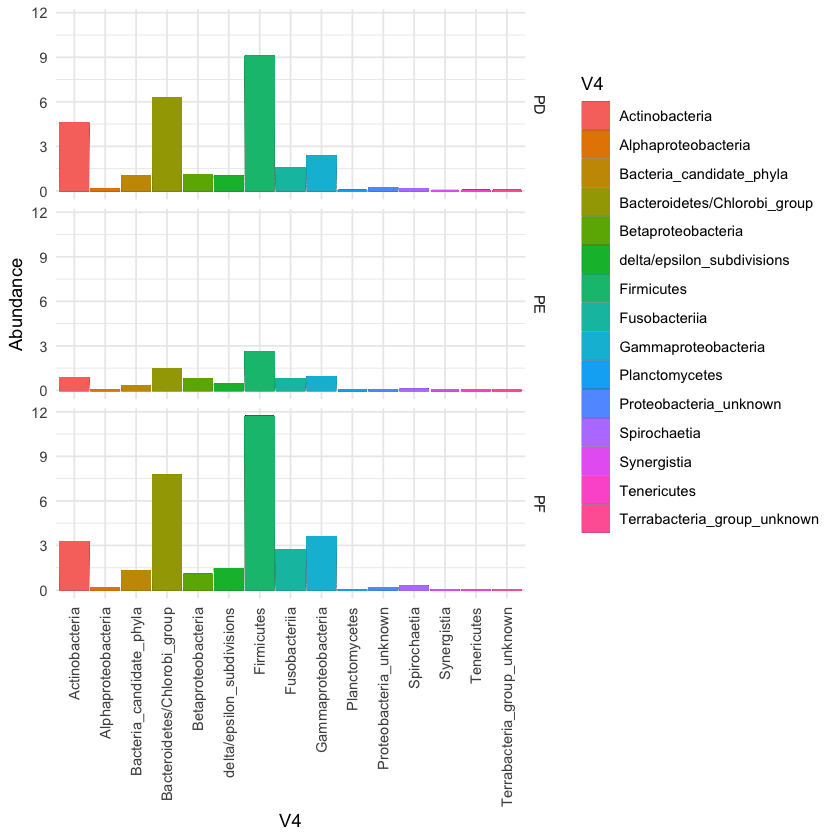

In [11]:
# phylum level figures
system("mkdir img")
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot by sample
taxbarsamp <- ggplot(data, aes(x=Sample, y=Abundance, fill=V4)) + geom_bar(aes(), stat="identity", position="stack") + theme_minimal() + theme(axis.text.x = element_text(angle = 90))
taxbarsamp
pdf("img/taxonomy_barchart.pdf")
taxbarsamp
dev.off()
# phyloseq group by tooth type
taxbargrp <- plot_bar(rel.abund, "V4", fill="V4", facet_grid="tooth_type") + geom_bar(aes(color=V4, fill=V4), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdf("img/tax_bar.tooth_type_by_sample.pdf")
taxbargrp
dev.off()

pdf 
  2

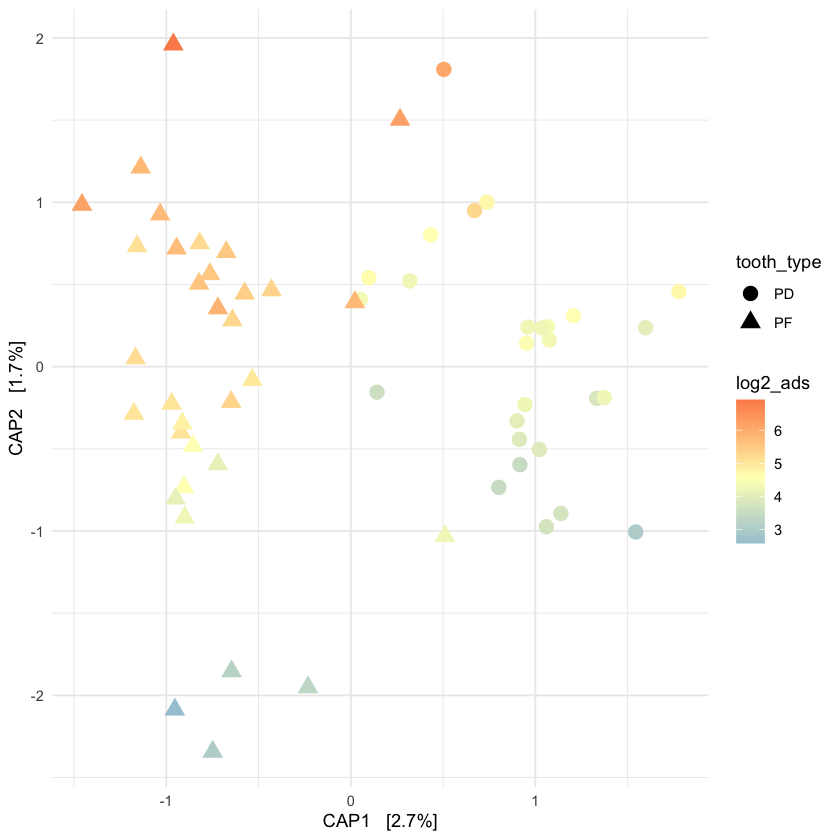

In [12]:
# only including PD and PF samples for now
ps.dat <- subset_samples(ps.dat, tooth_type !="PE")
# distance based redundancy analysis
sample_data(ps.dat)$ads_nmol_min_mg_of_protein <- as.integer(sample_data(ps.dat)$ads_nmol_min_mg_of_protein)
sample_data(ps.dat)$log2_ads <- log2(sample_data(ps.dat)$ads_nmol_min_mg_of_protein)

ordcap <- ordinate(ps.dat, "CAP", "bray", ~ tooth_type + log2_ads)
# add dummy variable to sample data as plot_ordination cannot handle only one metadata column
sample_data(ps.dat)[ , 2] <- sample_data(ps.dat)[ ,1]
mid <- median(sample_data(ps.dat)$log2_ads)
pdf("img/capscale_plt.tooth_type.pdf") 
plot_ordination(ps.dat, ordcap, color="log2_ads", shape="tooth_type") + theme_minimal() + geom_point(size=4) + scale_color_gradient2(midpoint=mid, low="#91bfdb", mid="#ffffbf", high="#fc8d59")
dev.off()
plot_ordination(ps.dat, ordcap, color="log2_ads", shape="tooth_type") + theme_minimal() + geom_point(size=4) + scale_color_gradient2(midpoint=mid, low="#91bfdb", mid="#ffffbf", high="#fc8d59")

In [13]:
# is the difference between the amount of arginine detected significant between tooth groups?
wilcox.test(sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PD",]$log2_ads, sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PF",]$log2_ads)

Warning message in wilcox.test.default(sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PD", ]$log2_ads and sample_data(ps.dat)[sample_data(ps.dat)$tooth_type == "PF", ]$log2_ads
W = 205, p-value = 0.0003572
alternative hypothesis: true location shift is not equal to 0


In [14]:
# philr transform data and distance matrix to perform permanova statistics
philr.dat <- transform_sample_counts(ps.dat, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
is.rooted(phy_tree(philr.dat)) # check that tree is rooted
is.binary(phy_tree(philr.dat)) #check that multichotomies are resolved in tree
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
# distance matrix
philr.dist <- dist(philr.t, method="euclidean")

[1] TRUE

[1] TRUE

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...



In [15]:
# permanova test
metadata <- as(sample_data(philr.dat), "data.frame")
adonis2(philr.dist ~ tooth_type, data=metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tooth_type,1,97.72199,0.05332025,3.266759,0.001
Residual,58,1735.01482,0.94667975,NA,NA
Total,59,1832.73680,1.00000000,NA,NA


In [16]:
# marginal effect of ads amount after controlling for tooth type
adonis2(philr.dist ~ tooth_type + log2_ads, data=metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tooth_type,1,97.72199,0.05332025,3.301037,0.001
log2_ads,1,47.61968,0.02598282,1.608587,0.028
Residual,57,1687.39514,0.92069692,NA,NA
Total,59,1832.73680,1.00000000,NA,NA



	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(philr.dat)$tooth_type)

No. of Positive Eigenvalues: 59
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PF 
5.154 4.863 

Eigenvalues for PCoA axes:
(Showing 8 of 59 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
188.11 160.15 120.66 100.61  97.64  80.72  75.63  66.93 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df  Sum Sq Mean Sq     F N.Perm Pr(>F)
Groups     1   1.255  1.2545 0.294    999  0.587
Residuals 58 247.453  4.2664                    

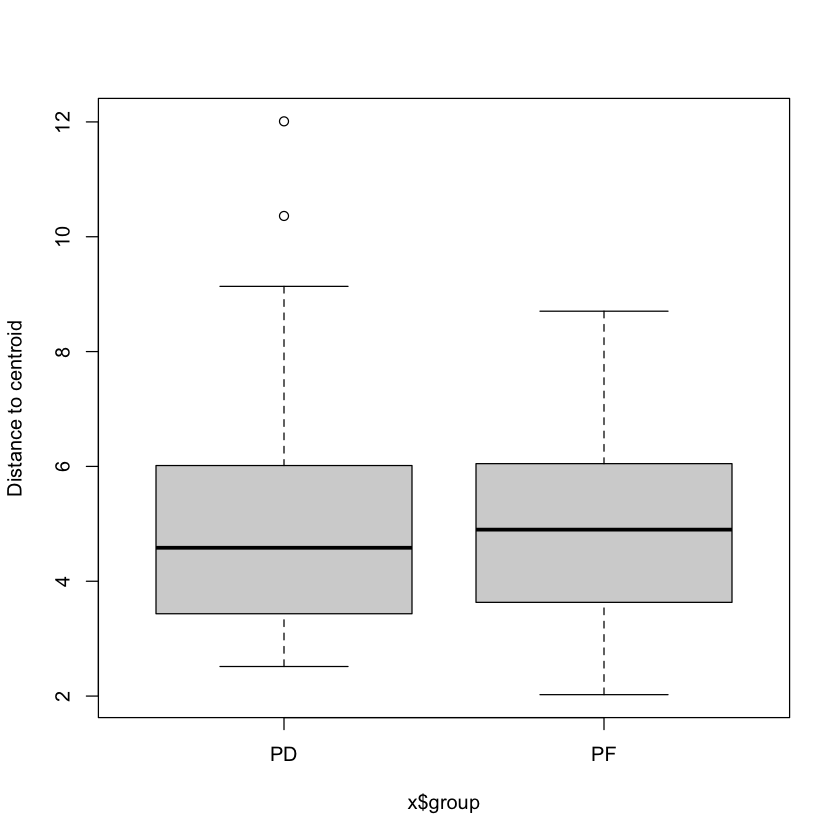

In [17]:
# beta dispersion test
dispr <- vegan::betadisper(philr.dist, phyloseq::sample_data(philr.dat)$tooth_type)
dispr
permutest(dispr)
boxplot(dispr)

pdf 
  2

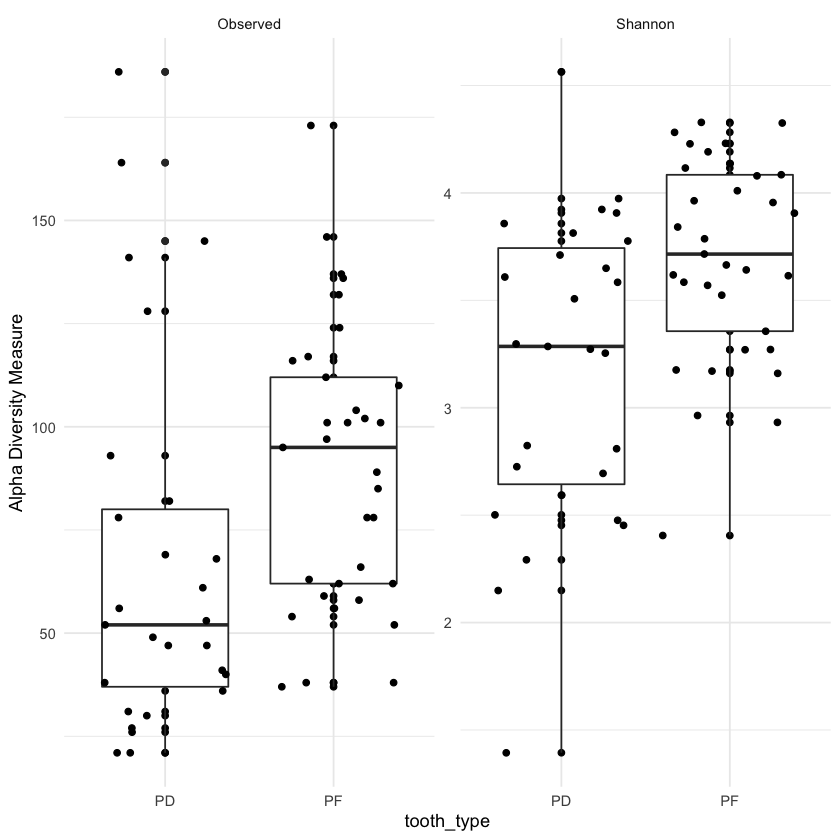

In [18]:
# alpha diversity
pdf("img/alpha_div.tooth_type.pdf")
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="tooth_type") + geom_boxplot() + theme_minimal() + geom_jitter()
dev.off()
plot_richness(ps.dat, measures=c("Observed", "Shannon"), x="tooth_type") + geom_boxplot() + theme_minimal() + geom_jitter()

pdf 
  2

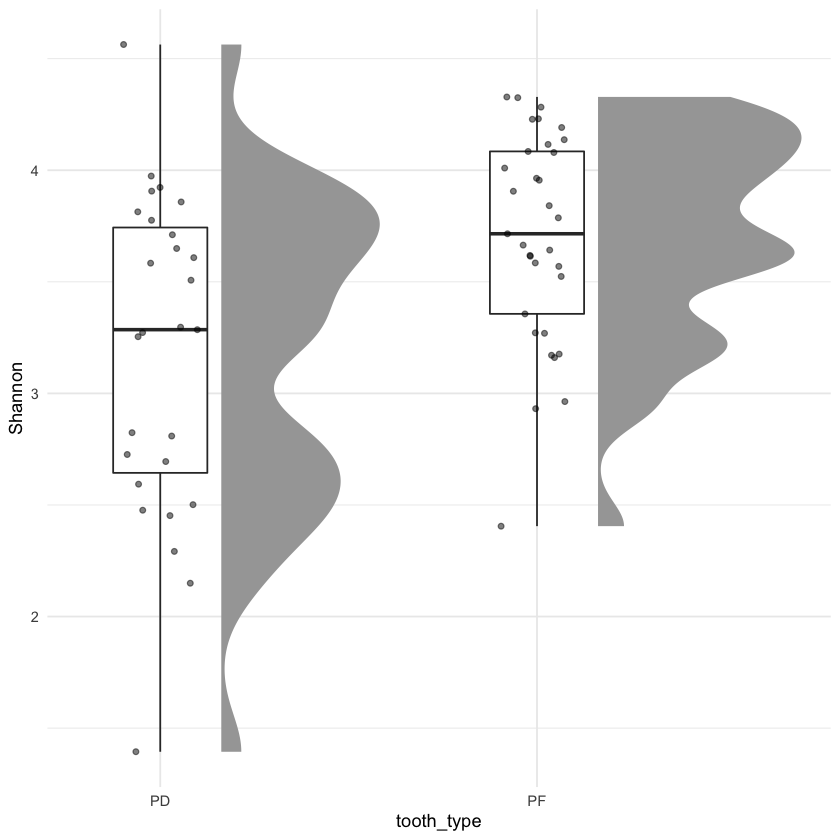

In [19]:
# install.packages("ggdist")
library(ggdist)
temp <- estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))
temp$tooth_type <- "PD"
temp1 <- estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))
temp1$tooth_type <- "PF"
alpha2 <- bind_rows(temp, temp1)

# raincloud plot
p <- ggplot(alpha2, aes(x = tooth_type, y = Shannon)) + 
  ggdist::stat_halfeye(
    adjust = .5, 
    width = .6, 
    .width = 0, 
    justification = -.3, 
    point_colour = NA) + 
  geom_boxplot(
    width = .25, 
    outlier.shape = NA
  ) +
  geom_point(
    size = 1.3,
    alpha = .5,
    position = position_jitter(
      seed = 1, width = .1
    )
  ) + 
    theme_minimal() +
  coord_cartesian(xlim = c(1.3, NA))
p
pdf("alphdiv_raincloud.pdf")
p
dev.off()

In [20]:
# significance tests
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed, estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed)
wilcox.test(estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon, estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon)

Warning message in wilcox.test.default(estimate_richness(subset_samples(ps.dat, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Observed and estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Observed
W = 260, p-value = 0.005968
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum exact test

data:  estimate_richness(subset_samples(ps.dat, tooth_type == "PD"))$Shannon and estimate_richness(subset_samples(ps.dat, tooth_type == "PF"))$Shannon
W = 250, p-value = 0.003272
alternative hypothesis: true location shift is not equal to 0


Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 23 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

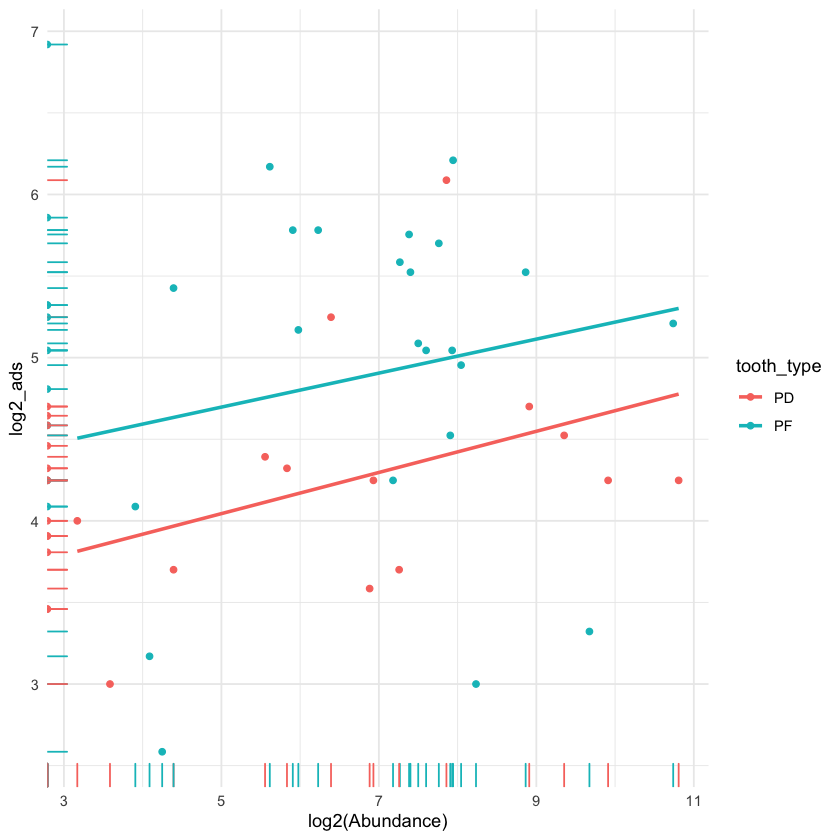

In [21]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_sanguinis")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 43 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

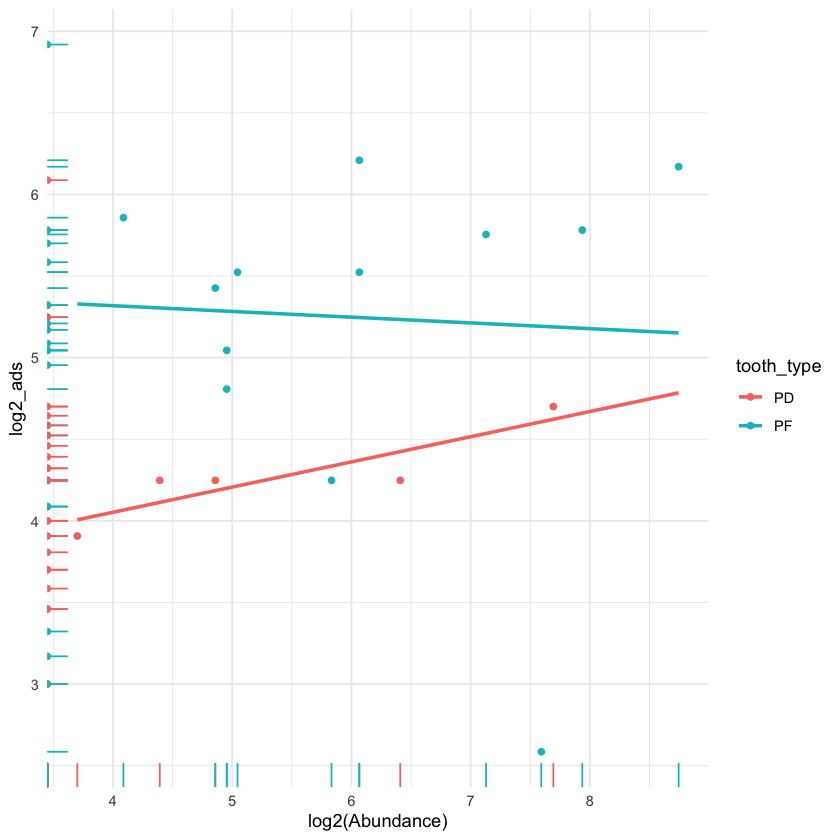

In [22]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_parasanguinis")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 42 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

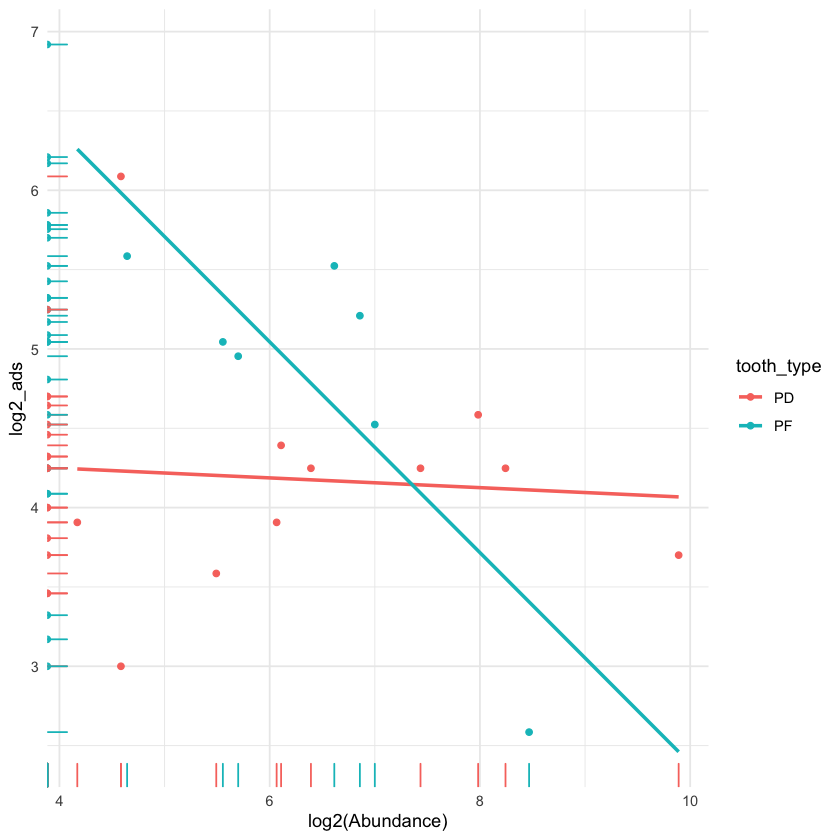

In [23]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_oralis")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 38 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

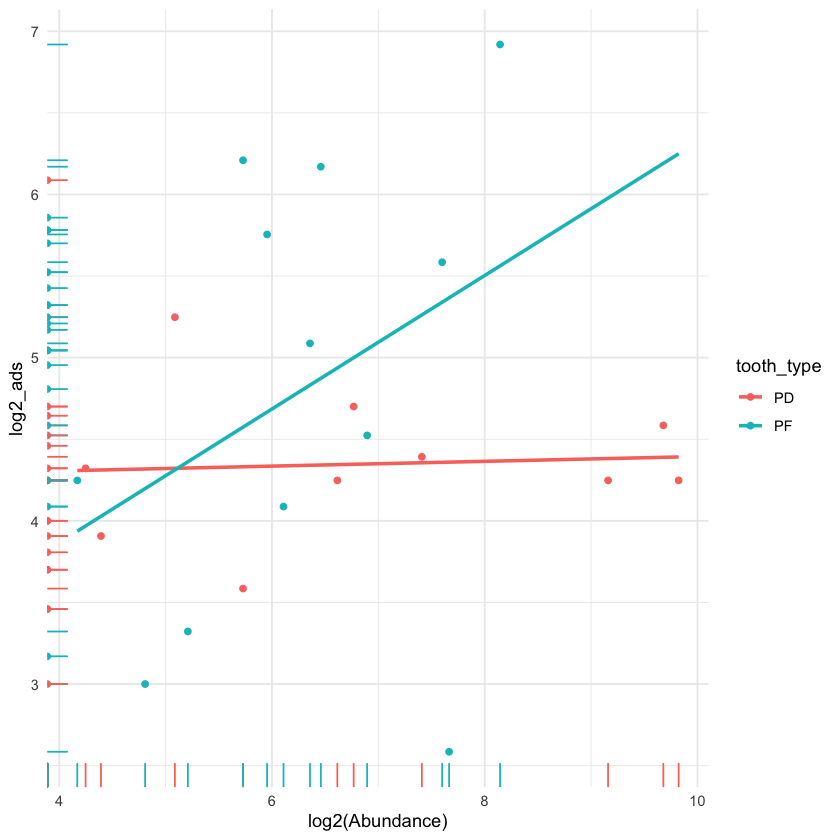

In [24]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_gordonii")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in FUN(X[[i]], ...):
“merge_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 36 rows containing non-finite values (stat_smooth).”


geom_rug: outside = FALSE, sides = bl, length = 0.03, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

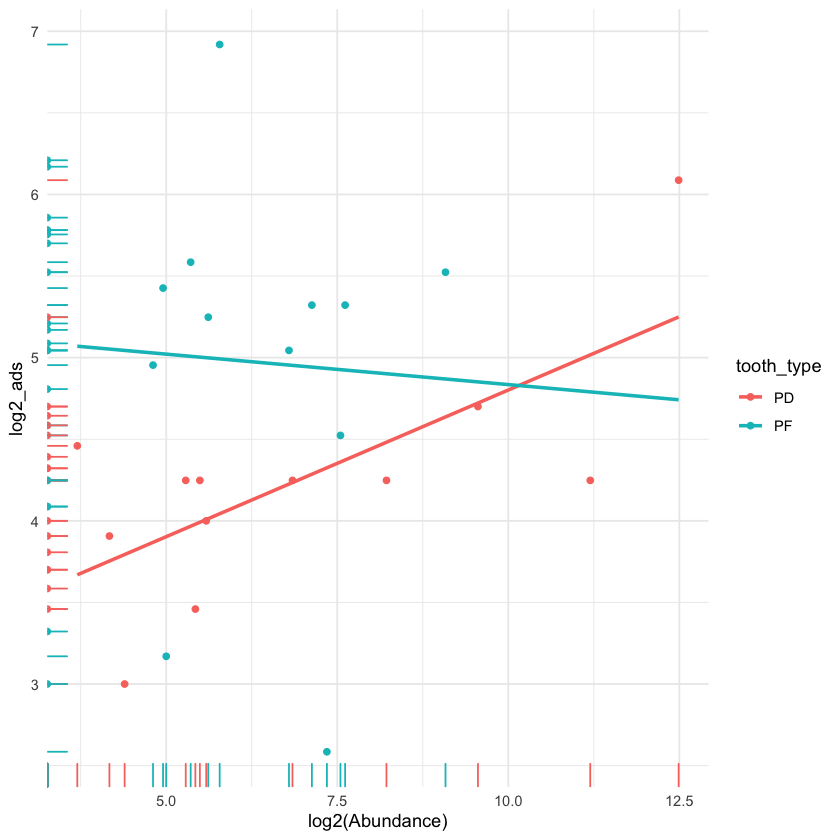

In [25]:
# proportion of different types of strep in pd vs pf
strep <- subset_taxa(ps.dat, V9=="Streptococcus_anginosus_group") # includes both constellatus and aginosus
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
data <- psmelt(glom) # create dataframe from phyloseq object
data$Sample <- factor(data$Sample, levels=unique(data$Sample))
# plot
ggplot(data, aes(x=log2(Abundance), y=log2_ads, color=tooth_type)) + 
    geom_point() + 
    theme_minimal() + 
    geom_smooth(method=lm, se=FALSE, fullrange=TRUE) +
    geom_rug()
geom_rug(sides ="bl")

Warning message in prune_taxa(taxa, phy_tree(x)):
“prune_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
ASV1495,Bacteria,Terrabacteria_group,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus_anginosus_group,Streptococcus_constellatus,Streptococcus_constellatus_unknown,Streptococcus_constellatus_unknown


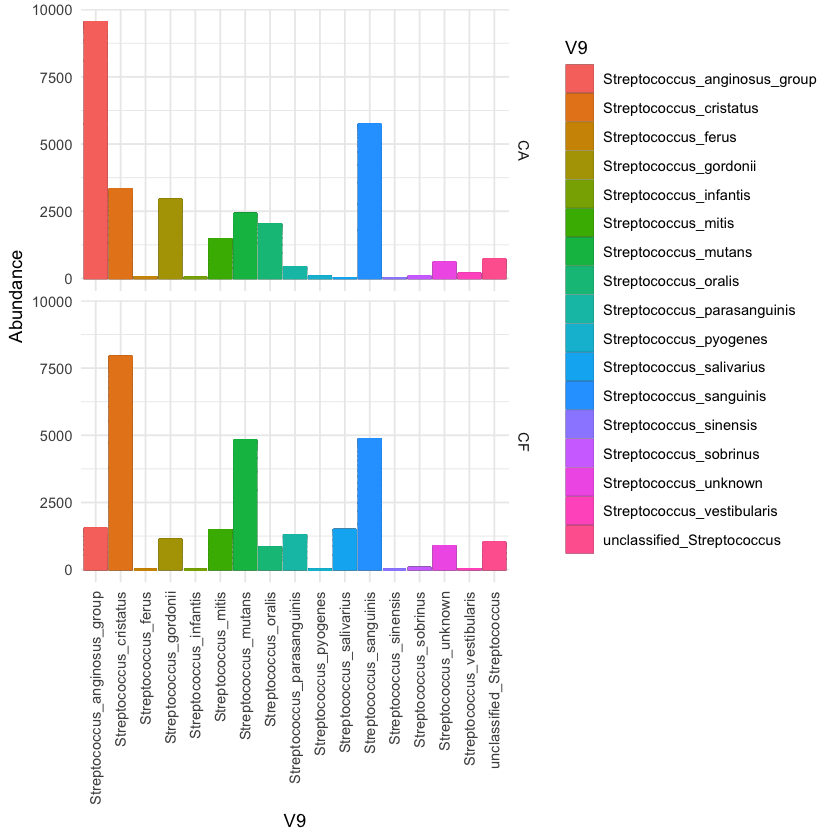

In [26]:
strep <- subset_taxa(ps.dat, V8=="Streptococcus")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
# what is proportion of different strep species in pd vs pf?
taxbargrp <- plot_bar(glom, "V9", fill="V9", facet_grid="caries_status") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

tax_table(subset_taxa(ps.dat, V10=="Streptococcus_constellatus"))

pdf 
  2

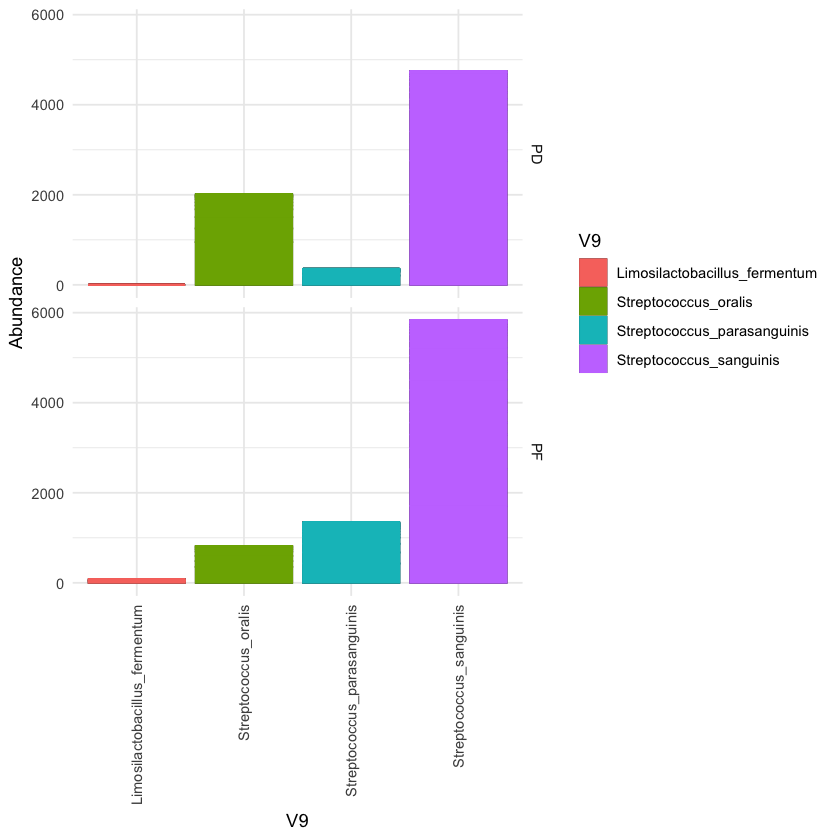

In [27]:
strep <- subset_taxa(ps.dat, V9=="Streptococcus_sanguinis" | V9=="Streptococcus_parasanguinis" | V9=="Streptococcus_oralis" | V9=="Limosilactobacillus_fermentum")
glom <- tax_glom(strep, taxrank=rank_names(strep)[8])
# what is proportion of species tagged in volcano plot in pd vs pf?
taxbargrp <- plot_bar(glom, "V9", fill="V9", facet_grid="tooth_type") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack")
pdf("bar_matching_volcano_plot.pdf")
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

pdf 
  2

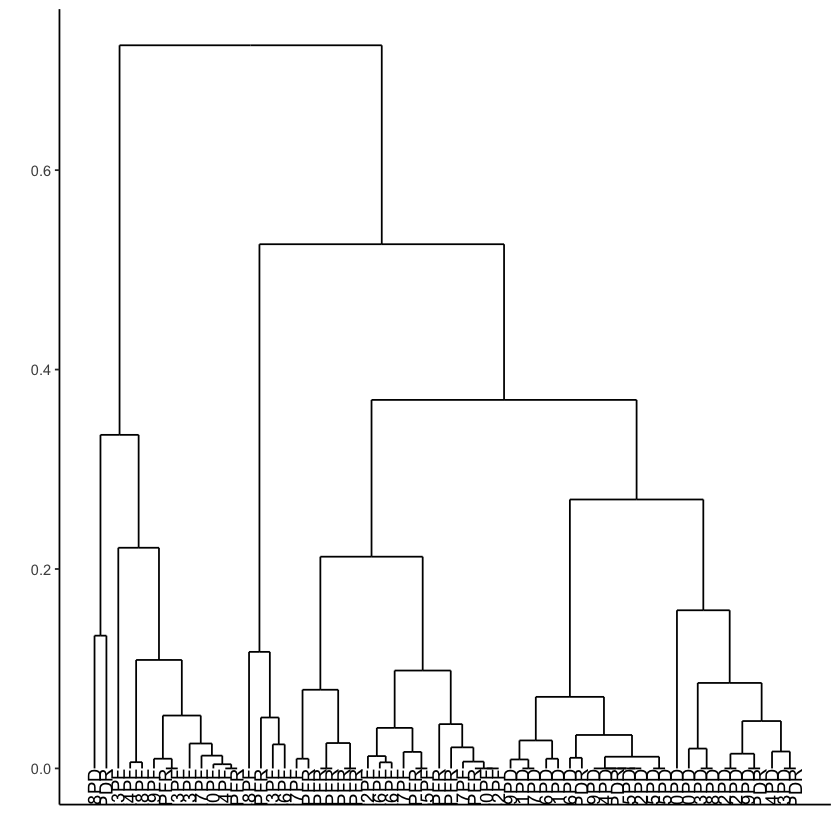

In [32]:
# heirarchical cluster dendrogram with corresponding taxonomy plot 
hc <- hclust(dist(ordcap$CCA$u), method="complete")
df2 <- data.frame(cluster=cutree(hc,5), states=factor(hc$labels, levels=hc$labels[hc$order])) # get cluster assocaited with each sample
write.table(df2, "philr_cluster.txt", quote=F, sep="\t", col.names=NA)
hcd <- as.dendrogram(hc)
dend_data <- dendro_data(hcd, type="rectangle")
tip_labels <- as.vector(dend_data$labels$label)
ggplot(dend_data$segments) +
    geom_segment(aes(x=x,y=y, xend=xend, yend=yend)) +
    theme_classic() +
    geom_text(data = dend_data$labels, aes(x, y, label = label, hjust = 1, angle = 90)) + 
    xlab("") + 
    ylab("") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
pdf("bdiv_dendrogram.pdf")
ggplot(dend_data$segments) +
    geom_segment(aes(x=x,y=y, xend=xend, yend=yend)) +
    theme_classic() +
    geom_text(data = dend_data$labels, aes(x, y, label = label, hjust = 1, angle = 90)) + 
    xlab("") + 
    ylab("") + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
dev.off()

In [45]:
dend_data$labels

x,y,label
<dbl>,<dbl>,<chr>
1,0,UF68PD
2,0,UF76PDR
3,0,UF23PF
4,0,UF24PF
5,0,UF8PF
6,0,UF79PF
7,0,UF64PFR
8,0,UF73PF
9,0,UF13PF
